In [26]:
import random
import numpy as np

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

from models import MLP, NAC, NALU

In [33]:
NORMALIZE = True
NUM_LAYERS = 4
HIDDEN_DIM = 4
LEARNING_RATE = 1e-2
EPOCHS = int(2e4)
RANGE = [0, 10]
USE_CUDA = True
AVERAGE_RANDOM_NETS = 1000
TRAIN_SET = 5000
TEST_SET = 5000
ARITHMETIC_FUNCTIONS = {
    'add': lambda x, y: x + y,
    'sub': lambda x, y: x - y,
    'mul': lambda x, y: x * y,
    'div': lambda x, y: x / y,
    'squared': lambda x, y: torch.pow(x, 2),
    'root': lambda x, y: torch.sqrt(x),
    'log': lambda x, y: torch.log(x)
}

In [28]:
if USE_CUDA and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

models = [
    NALU(
        num_layers=NUM_LAYERS,
        in_dim=2,
        hidden_dim=HIDDEN_DIM,
        out_dim=1,
        device=device
    ),
]

In [29]:
def generate_data(num_train, num_test, dim, num_sum, fn, support, device):
    data = torch.zeros([dim, 1], dtype=torch.float).uniform_(*support)
    X, y = [], []
    for i in range(num_train + num_test):
        idx_a = random.sample(range(dim), num_sum)
        idx_b = random.sample([x for x in range(dim) if x not in idx_a], num_sum)
        a, b = data[idx_a].sum(), data[idx_b].sum()
        X.append([a, b])
        y.append(fn(a, b))
    X = torch.tensor(data=X, dtype=torch.float, device=device)
    y = torch.tensor(data=y, dtype=torch.float, device=device).unsqueeze_(1)
    indices = list(range(num_train + num_test))
    np.random.shuffle(indices)
    X_train, y_train = X[indices[num_test:]], y[indices[num_test:]]
    X_test, y_test = X[indices[:num_test]], y[indices[:num_test]]
    return X_train, y_train, X_test, y_test

def train(model, optimizer, data, target, num_iters):
    losses = []
    means = []
    for i in range(1, num_iters + 1):
        out = model(data)
        loss = F.mse_loss(out, target)
        mea = torch.mean(torch.abs(target - out))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        mean_diff = mea.item()
        losses.append(loss_val)
        means.append(mea.item())
        print(f'\r epoch: [{i+1}/{num_iters}], loss: {loss_val}, mean_diff: {mean_diff}', end='')
    return losses, means

def test(model, data, target):
    with torch.no_grad():
        out = model(data)
        return torch.abs(target - out)

In [ ]:
results = {}
for fn_str, fn in ARITHMETIC_FUNCTIONS.items():
    print('[*] Testing function: {}'.format(fn_str))
    results[fn_str] = []

    # dataset
    X_train, y_train, X_test, y_test = generate_data(
        num_train=TRAIN_SET, num_test=500,
        dim=100, num_sum=5, fn=fn,
        support=RANGE, device=device
    )

    # random model
    random_mse = []
    for i in range(AVERAGE_RANDOM_NETS):
        net = MLP(
            num_layers=NUM_LAYERS, in_dim=2,
            hidden_dim=HIDDEN_DIM, out_dim=1,
            activation='relu6', device=device
        )
        mse = test(net, X_test, y_test)
        random_mse.append(mse.mean().item())
    results[fn_str].append(np.mean(random_mse))

    # others
    for net in models:
        print("\tTraining {}...".format(net.__str__().split("(")[0]))
        optim = torch.optim.RMSprop(net.parameters(), lr=LEARNING_RATE)
        losses, means = train(net, optim, X_train, y_train, EPOCHS)
        mse = test(net, X_test, y_test).mean().item()
        print("\t\tTest finished {}".format(mse))
        results[fn_str].append((mse, losses, means))
        epochs = np.arange(EPOCHS)
        plt.figure()
        plt.plot(epochs, losses)
        plt.yscale('log')
        plt.title('Losses in net {} on function {}'.format(net.__str__().split("(")[0], fn_str))
        plt.show()

    print("\n---------------RESULTS------------------")

    print("Operation\tNALU")
    for k, v in results.items():
        print("{}\t".format(k), end='')
        rand = results[k]
        for ms in results[k][1:]:
            print("{:.3f}\t".format(ms[0]), end='')
        print()

    for k, v in results.items():
        print("{}\t".format(k), end='')
        rand = results[k][0]
        mses = [100.0 * x[0] / rand for x in results[k][1:]]
        for ms in mses:
            print("{:.3f}\t".format(ms), end='')
        print()

[*] Testing function: add
	Training NALU...
 epoch: [9755/20000], loss: 0.42482444643974304, mean_diff: 0.60617810487747196

C:\Users\ME\.conda\envs\env1\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
C:\Users\ME\.conda\envs\env1\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
C:\Users\ME\.conda\envs\env1\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a pr

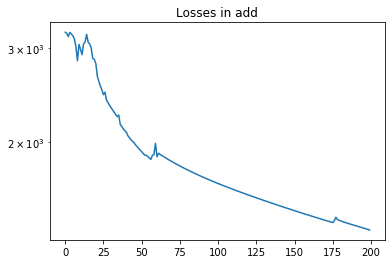

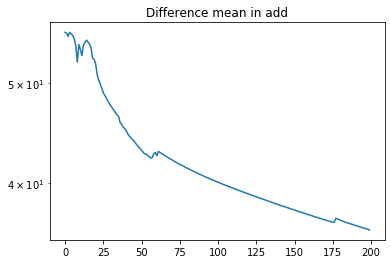

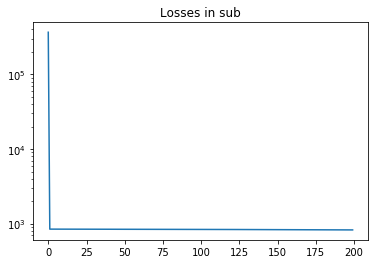

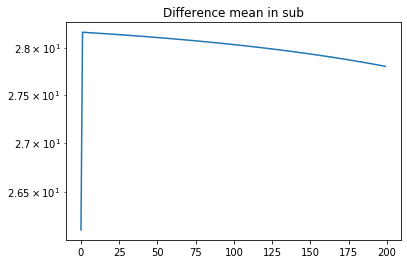

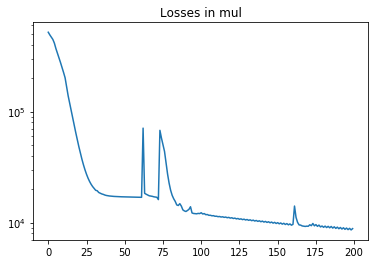

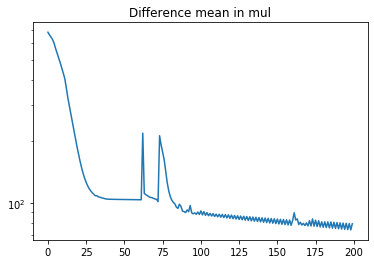

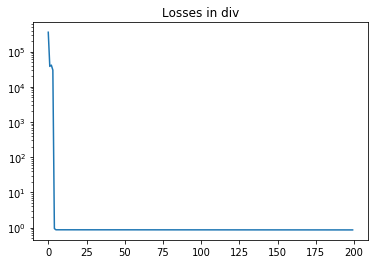

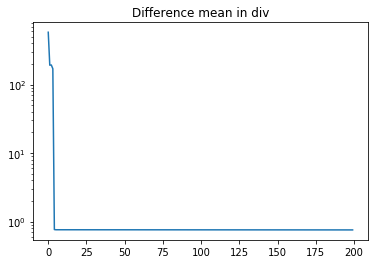

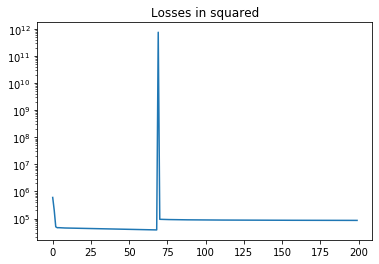

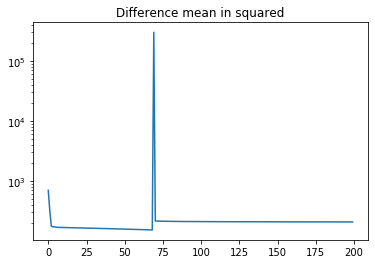

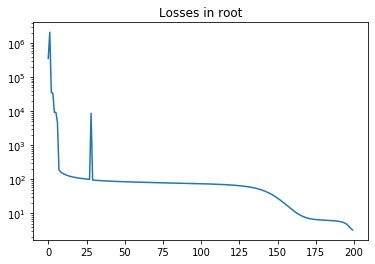

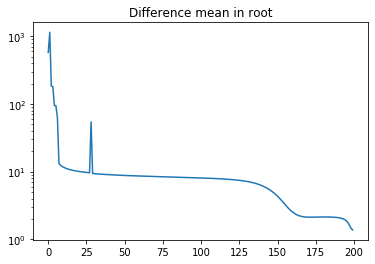

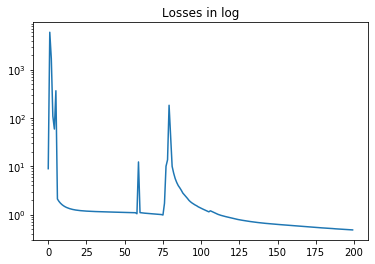

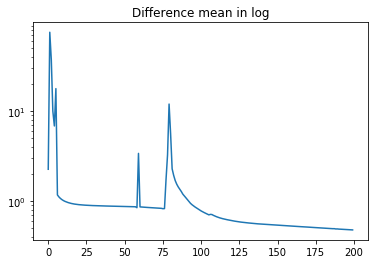

In [31]:
for k, av in results.items():
    epochs = np.arange(EPOCHS)
    v, losses, means = av[1]
    plt.figure()
    plt.plot(epochs, losses)
    plt.yscale('log')
    plt.title('Losses in {}'.format(k))
    plt.figure()
    plt.plot(epochs, means)
    plt.yscale('log')
    plt.title('Difference mean in {}'.format(k))
    plt.subplot()
    plt.show()

In [32]:

for k, v in results.items():
    print("{}\t".format(k), end='')
    rand = results[k][0]
    mses = [100.0 * x[0] / rand for x in results[k][1:]]
    for ms in mses:
        print("{:.3f}\t".format(ms), end='')
    print()

add	64.203	
sub	383.836	
mul	11.207	
div	66.805	
squared	28.683	
root	26.770	
log	16.151	
